In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold

In [2]:
# Parameter
train_dir = "./dataset/hsv_masking/train"
validation_dir = "./dataset/rgb/val"
k = 3  # Jumlah fold untuk K-FCV
epochs = 5  # Jumlah epoch untuk training model per fold

In [3]:
# Import data
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=64,
    class_mode="categorical",
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=64,
    class_mode="categorical",
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './dataset/hsv_masking/train'

In [7]:
def get_batch(generator, index):
    data = []
    labels = []
    for i in index:
        x, y = generator[i]
        data.extend(x)
        labels.extend(y)
    return np.array(data), np.array(labels)

In [8]:
# Membuat model CNN
def create_model():
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 300, 3)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

model = create_model()
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │       524,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,531 (2.50 MB)

 Trainable params: 654,531 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# Evaluasi dengan K-FCV
history_list = []
average_acc = 0
average_loss = 0

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_generator):
    # Dapatkan batch data pelatihan dan validasi berdasarkan indeks fold
    train_data, train_labels = get_batch(train_generator, train_index)
    val_data, val_labels = get_batch(train_generator, val_index)

    # Buat model baru untuk setiap fold
    model = create_model()

    # Latih model menggunakan data pelatihan
    history = model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        verbose=1,  # Tampilkan informasi training per epoch
    )

    history_list.append(history.history)

    # Hitung rata-rata akurasi dan loss
    average_acc += history.history['val_accuracy'][-1]
    average_loss += history.history['val_loss'][-1]

average_acc /= k
average_loss /= k

print(f"Average Accuracy: {average_acc}")
print(f"Average Loss: {average_loss}")

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 717ms/step - accuracy: 0.5438 - loss: 1.0027 - precision_2: 0.7494 - recall_2: 0.0832 - val_accuracy: 0.8867 - val_loss: 0.4079 - val_precision_2: 0.9799 - val_recall_2: 0.7617
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 696ms/step - accuracy: 0.8215 - loss: 0.3860 - precision_2: 0.8991 - recall_2: 0.7742 - val_accuracy: 0.9414 - val_loss: 0.1675 - val_precision_2: 0.9486 - val_recall_2: 0.9375
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 689ms/step - accuracy: 0.8852 - loss: 0.2498 - precision_2: 0.9176 - recall_2: 0.8717 - val_accuracy: 0.9688 - val_loss: 0.1158 - val_precision_2: 0.9686 - val_recall_2: 0.9648
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 681ms/step - accuracy: 0.9094 - loss: 0.2065 - precision_2: 0.9321 - recall_2: 0.8818 - val_accuracy: 0.9766 - val_loss: 0.0696 - val_precision_2: 0.9766 - val_recall_2: 0.9766
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 672ms/step - accuracy: 0.9177 - loss: 0.1666 - precision_2: 0.9466 - recall_2: 0.9085 -

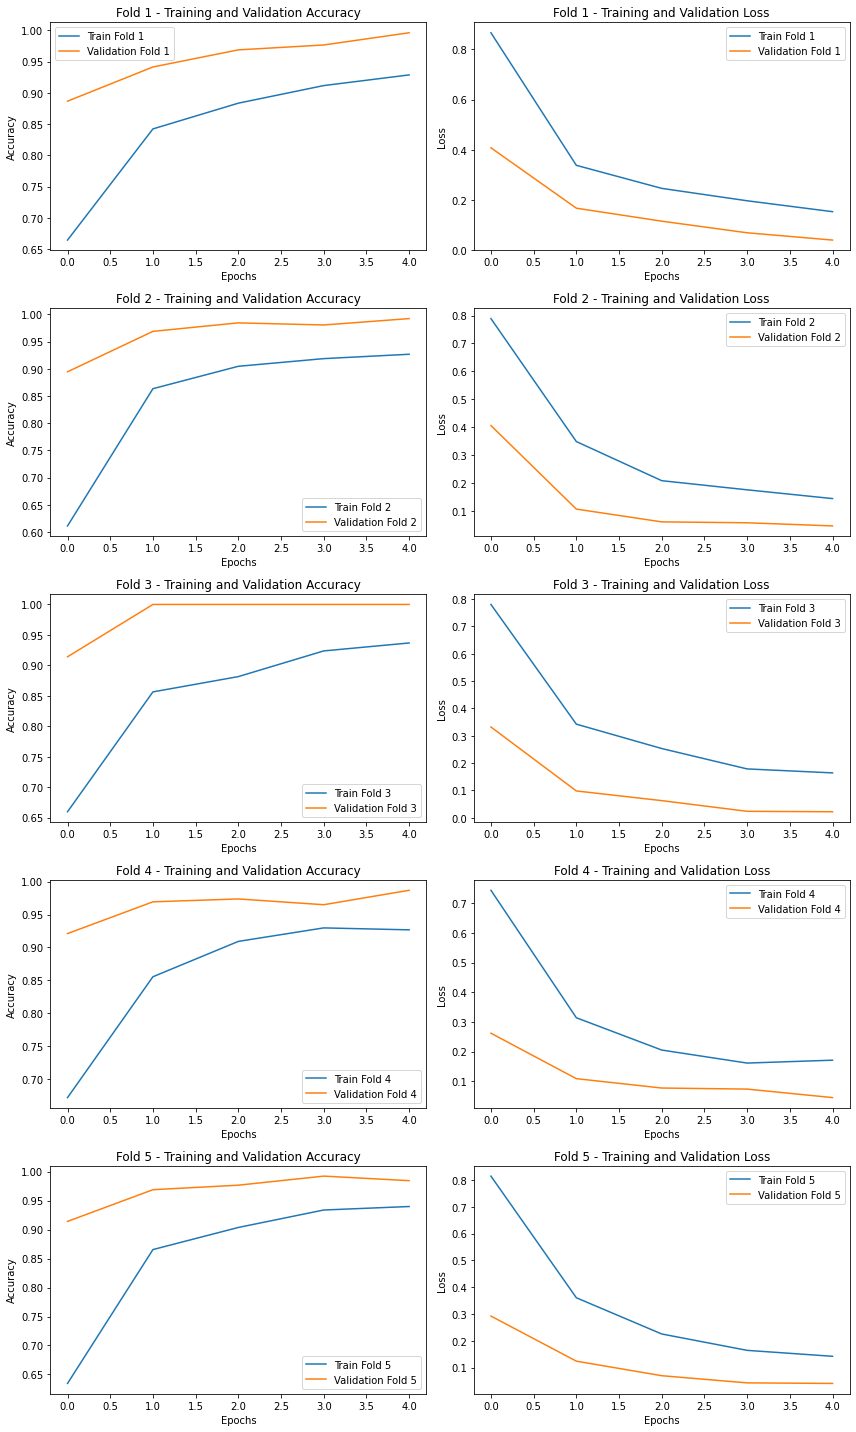

In [14]:
# Plotting hasil training dan validasi untuk setiap fold
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

for i, history in enumerate(history_list):
    # Plot Accuracy
    axs[i, 0].plot(history['accuracy'], label=f'Train Fold {i+1}')
    axs[i, 0].plot(history['val_accuracy'], label=f'Validation Fold {i+1}')
    axs[i, 0].set_title(f'Fold {i+1} - Training and Validation Accuracy')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('Accuracy')
    axs[i, 0].legend()

    # Plot Loss
    axs[i, 1].plot(history['loss'], label=f'Train Fold {i+1}')
    axs[i, 1].plot(history['val_loss'], label=f'Validation Fold {i+1}')
    axs[i, 1].set_title(f'Fold {i+1} - Training and Validation Loss')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()